In [1]:
import gym
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("white")
%matplotlib inline

# Environment setup

In [2]:
# Reward distribution
mu, sigma = 0, 1
k = 10
action_values = np.random.normal(mu, sigma, k).tolist() #q*(a)
reward_dist = [[q, 1] for q in action_values]

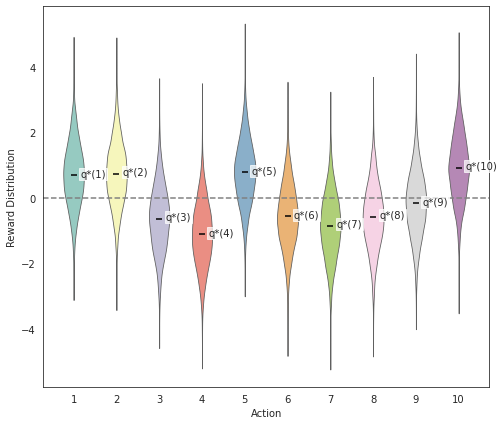

In [64]:
# Plotting the reward distributions

fig = plt.figure(figsize=(8,7))

df = pd.DataFrame()
for idx, e in enumerate(reward_dist):
    y = np.random.normal(e[0], e[1], 10000)
    df[idx+1]=pd.Series(y)
    
g = sns.violinplot(data=df, linewidth=0.8, inner=None, width=0.5, palette="Set3")
plt.scatter(x=range(len(action_values)), y=action_values, marker="_", color="black")

for idx, v in enumerate(action_values):
    plt.text(idx+0.15, v-0.05,'q*({})'.format(idx+1), 
             fontsize=10,
             bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 1})

g.axhline(0, ls='--', c="gray")
    
plt.xlabel("Action")
plt.ylabel("Reward Distribution")
plt.show()


In [4]:
env = gym.make('gym_bandits:karmedbandits-v0', r_dist=reward_dist)

In [5]:
np.random.seed(42) 
env.seed(42)

In [6]:
print(env.action_space)
print(env.observation_space)

Discrete(10)
Discrete(1)


In [7]:
obs = env.reset()

for ep in range(5):
    print("Episode:", ep)
    a = env.action_space.sample()
    print("Action:", a)
    obs, r, _, _ = env.step(a)
    
    print("Observation: ", obs)
    print("Reward: {:.2f}".format(r))
    print()
    
env.close()

Episode: 0
Action: 3
Observation:  0
Reward: -0.62

Episode: 1
Action: 0
Observation:  0
Reward: 0.54

Episode: 2
Action: 1
Observation:  0
Reward: 1.38

Episode: 3
Action: 5
Observation:  0
Reward: 0.95

Episode: 4
Action: 5
Observation:  0
Reward: -0.81



# ε-greedy Agent

In [98]:
# Epsilon-greedy agent with optimistic initial values 

def epsilon_greedy_agent(bandits,
                         epsilon=0.1, 
                         initial=5.0, 
                         episodes=1000):
    
    Q = np.full(k, initial)
    N = np.zeros(k)
    epsilon = epsilon
    
    r_list = []
    
    obs = bandits.reset()
    for ep in range(episodes):
        p = np.random.random()
        
        if p <= epsilon: 
            # Exploration
            a = np.random.randint(k)
        else: 
            # Exploitation
            a = np.argmax(Q)
            
        _, r, _, _ = bandits.step(a)

        # Update tables
        N[a]+=1
        Q[a] = Q[a]+(r-Q[a])/N[a]
        r_list.append(r)
    
    return Q, N, r_list

In [121]:
episodes = 1000
Q, N, r = epsilon_greedy_agent(env, episodes=episodes)

In [122]:
best_bandit = np.argmax(Q)+1
real_best_bandit = np.argmax(action_values)+1

print(best_bandit)
print(real_best_bandit)

10
10


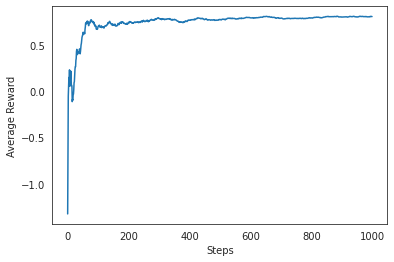

In [123]:
cum_reward = np.cumsum(r)/(np.arange(episodes)+1)
plt.plot(cum_reward)
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.show()
